<a href="https://colab.research.google.com/github/Oswaldo09178/twitter-discourse-mali/blob/main/Twitter_Discourse_and_Public_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import dask.dataframe as dd
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
from transformers import pipeline
import re
import dask
# !pip install emoji --upgrade
import emoji
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# !gdown 1HbGToGFvKc3mYaNEOptAkrW0xyNZSuCE

# Data Preprocessing

In [ ]:
df = pd.read_csv(
    'filtered_tweets.csv',
    encoding='ISO-8859-1',              # Or try 'ISO-8859-1' if UTF-8 fails
    on_bad_lines='skip',
    dtype=str,
    engine='python'                # Use Python engine to avoid C parser overflow
)
# Access the first partition directly
# df.head()

# Part 1 - DEA (Data Exploratory Analysis)

In [ ]:
df_filtered_french = df.copy()
df_filtered_french.dropna(subset=['userLocation'], inplace=True)
df_filtered_french = df_filtered_french.set_index(pd.to_datetime(df_filtered_french['createdAtDateTweet']))
df_filtered_french = df_filtered_french.loc['2021-05-01':]
max_date_in_the_data = df_filtered_french.index.max()
print(f"Max date in the data: {max_date_in_the_data}") #2022-06-22 00:00:00
df_filtered_french.head()
display(len(df_filtered_french)) #29059

user_with_at_least_10_tweets = len(df_filtered_french['userId'].value_counts()[df_filtered_french['userId'].value_counts() >= 10])
print(f"Number of unique users in the dataset: {len(df_filtered_french['userId'].unique())}")
print(f"Number of users with at least 10 tweets: {user_with_at_least_10_tweets}")

Max date in the data: 2022-06-22 00:00:00


29059

Number of unique users in the dataset: 3393
Number of users with at least 10 tweets: 590


## Authors in Mali vs Authors outside of Mali

13383


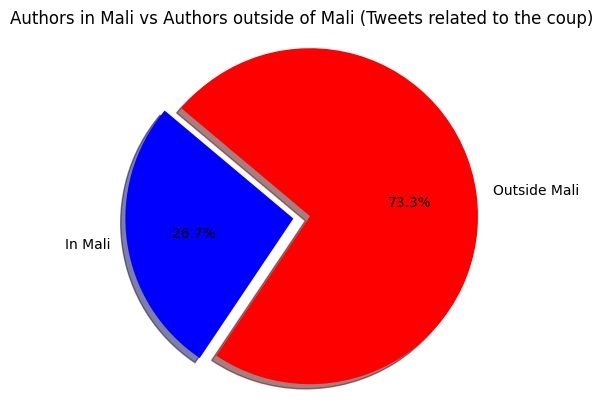

In [ ]:
number_of_authors_in_Mali = df_filtered_french[df_filtered_french["userLocation"].str.contains('Mali')].shape[0]
print(number_of_authors_in_Mali)

#Plotting number of people in Mali vs number of people outside (Pie chart)
labels = 'In Mali', 'Outside Mali'
sizes = [number_of_authors_in_Mali, df.shape[0]-number_of_authors_in_Mali]
colors = ['blue', 'red']
explode = (0.1, 0)  # explode 1st slice
plt.title("Authors in Mali vs Authors outside of Mali (Tweets related to the coup)")
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Evolution of tweets over time

/usr/local/lib/python3.11/dist-packages/dask_expr/_expr.py:1471: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return get_meta_library(args[0]).to_datetime(*args, **kwargs)


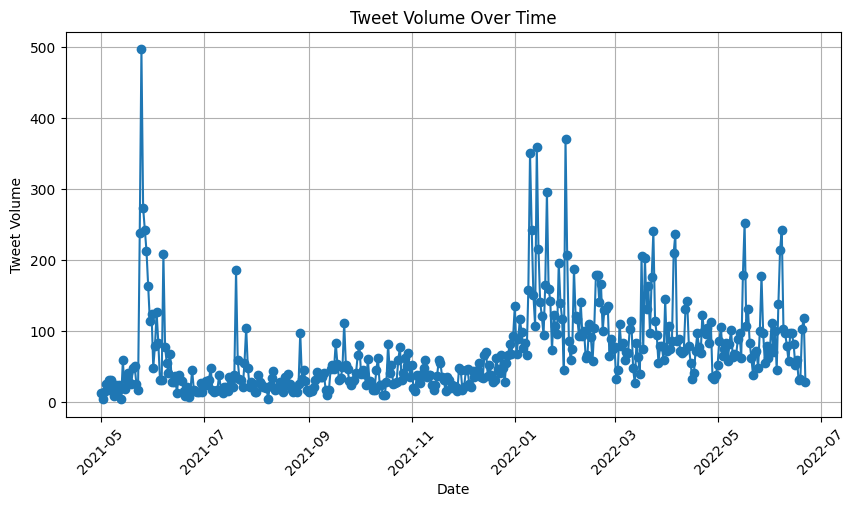

In [ ]:
df_filtered_french['createdAtDateTweet'] = dd.to_datetime(df_filtered_french['createdAtDateTweet'], errors='coerce')
df_filtered_french['createdAtTimeTweet'] = dd.to_datetime(df_filtered_french['createdAtTimeTweet'], errors='coerce')
tweet_volume = df_filtered_french.groupby(df_filtered_french['createdAtDateTweet'].dt.date).size()
plt.figure(figsize=(10, 5))
plt.plot(tweet_volume.index, tweet_volume.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Tweet Volume')
plt.title('Tweet Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# total_tweets = df_filtered_french['tweetId'].nunique().
# print(f"Total number of tweets: {total_tweets}")

## Hourly, Daily and weekly distribution of tweets

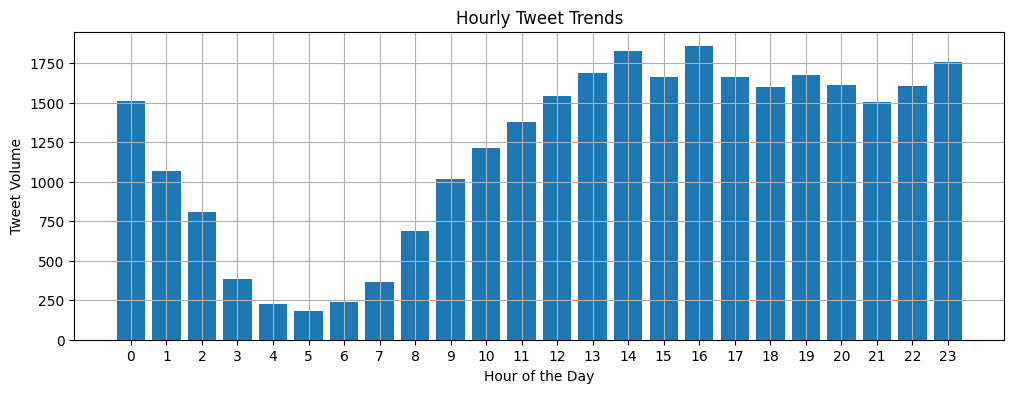

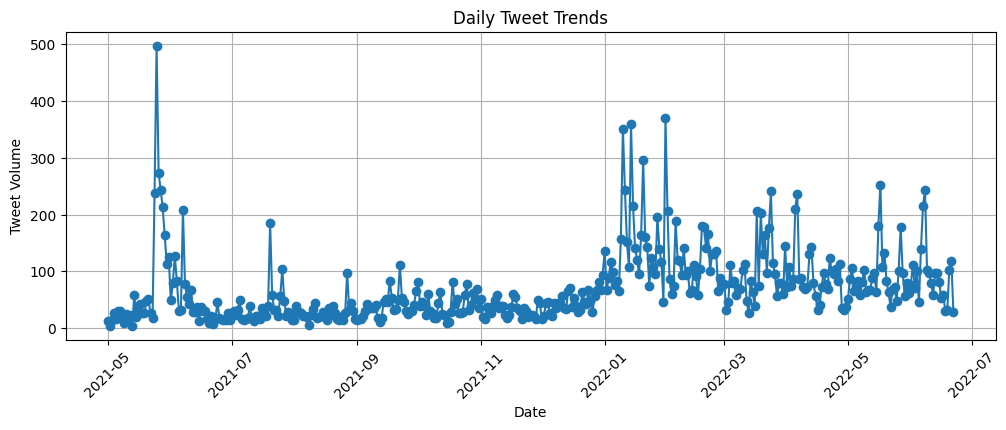

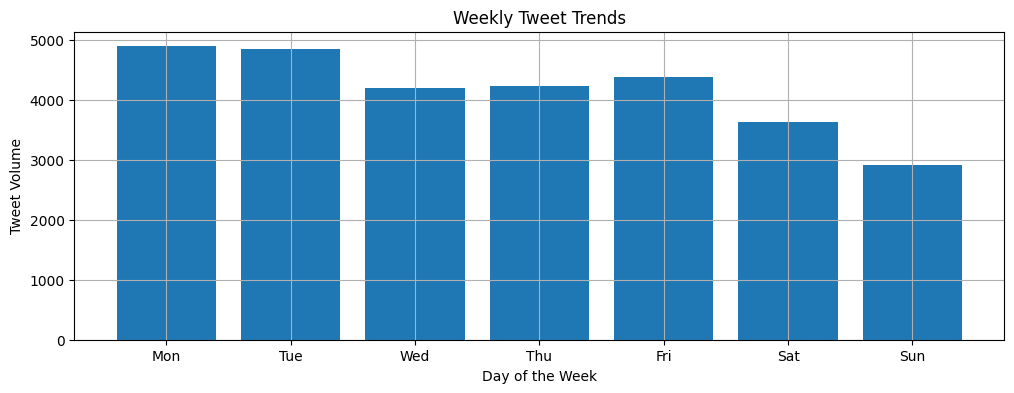

In [ ]:
# Extract temporal components (assuming you use Dask properly for further processing)
df_filtered_french['hour'] = df_filtered_french['createdAtTimeTweet'].dt.hour
df_filtered_french['day'] = df_filtered_french['createdAtDateTweet'].dt.date
df_filtered_french['weekday'] = df_filtered_french['createdAtDateTweet'].dt.weekday  # 0 = Monday, 6 = Sunday

#  tweet volume per hour
hourly_trend = df_filtered_french.groupby('hour').size()
# print(hourly_trend)

#  tweet volume per day
daily_trend = df_filtered_french.groupby('day').size()
# print(daily_trend)

#  tweet volume per weekday
weekly_trend = df_filtered_french.groupby('weekday').size()

# Plot hourly trends (Bar chart)
plt.figure(figsize=(12, 4))
plt.bar(hourly_trend.index, hourly_trend.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Tweet Volume')
plt.title('Hourly Tweet Trends')
plt.grid(True)
plt.xticks(range(0, 24))  # Ensure the x-axis shows 0 to 23 hours
plt.show()

# Plot daily trends (Line chart)
plt.figure(figsize=(12, 4))
plt.plot(daily_trend.index, daily_trend.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Tweet Volume')
plt.title('Daily Tweet Trends')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot weekly trends (Bar chart)
plt.figure(figsize=(12, 4))
plt.bar(weekly_trend.index, weekly_trend.values, tick_label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],)
plt.xlabel('Day of the Week')
plt.ylabel('Tweet Volume')
plt.title('Weekly Tweet Trends')
plt.grid(True)
plt.show()


## Top retweeted tweets

In [ ]:
# df_filtered_french['likes'] = df['likes'].map_partitions(pd.to_numeric, errors='coerce').fillna(0)
df_filtered_french['retweetCount'] = pd.to_numeric(df_filtered_french['retweetCount'], errors='coerce').fillna(0)

# Find the top 10 most retweeted tweets
top_retweeted = df_filtered_french.nlargest(10, 'retweetCount')[['tweetText', 'retweetCount']]

# Display results
print("Top 10 Most Retweeted Tweets:")
pd.set_option('display.max_colwidth', None)
display(top_retweeted)


Top 10 Most Retweeted Tweets:


,tweetText,retweetCount
createdAtDateTweet,,
2022-01-31,Suite aux propos tenus par les autorités françaises à lendroit des autorités de la Transition SEM Joel MEYER Ambassadeur de la République française au Mali est convoqué ce lundi 31 janvier 2022 au #MAECI.,383.0
2022-03-04,#Mali ~40 militaires FAMa tués dans une attaque du #JNIM #AQMI contre la base de #Mondoro les militaires maliens nont pas pu bénéficier dappui aérien #Barkhane pour repousser comme ce fut le cas le 23-24 janvier 2021. Zone où actuellement des operatifs russes sont actifs https://t.co/Jqws4RINLa,322.0
2022-02-20,"On pause fièrement aux côtés du putschiste"" halal"" au même moment le Mali vit sous embargo total. Elles sont Étonnantes les valeurs républicaines gauloises!! https://t.co/tDEAL69wHN",276.0
2022-04-05,Toujours la faute c'est l'armée malienne quand ils sont attaqué c'est des lâches ou ne sont pas sérieux quand ils tombent dans l'embuscade c'est des immature ou des amateurs mais quand c'est eux qui attaquent c'est exactions. Force =ª à nos Fama <ò<ñ https://t.co/nK9muJqxAz,271.0
2022-06-20,Le Président de la Transition SE le Colonel Assimi GOÏTA Chef de lÉtat s'est rendu ce lundi à Samanko dans la commune rurale du Mandé pour la remise de 225 tracteurs aux producteurs agricoles. https://t.co/1Qqw1kl2yA,261.0
2022-01-15,"Assimi Goita: ""Cette mobilisation prouve à suffisance que les autorités maliennes parlent au nom du peuple Malien"" #Mali #CEDEAO #France https://t.co/oKY2uvpXSV",241.0
2021-05-24,#Mali Le Président de transition et son Premier Ministre aux mains des militaires sont toujours dans la ville garnison de Kati près de bamako . Pour le moment il a été demandé à leurs chauffeurs et gardes qui les accompagnaient de redescendre seuls la capitale . A suivre ....,210.0
2022-02-09,Communiqué du Gouvernement du Mali relatif à la mise en place dun mécanisme de concertation avec la CEDEAO lUA & la communauté internationale ds le cadre de la recherche de solutions consensuelles pr une transition réussie consacrant le retour à 1 ordre constitutionnel normal. https://t.co/ApbJrseadC,209.0
2022-03-31,Les marcheurs panafricains qui ont parcouru la distance Dakar-Bamako longue de 1360 km pour manifester leur solidarité au peuple malien ont été reçus jeudi 31 mars 2022 par le Président de la Transition SE le Colonel Assimi GOÏTA Chef de lÉtat. https://t.co/uMkiDaN5GU,195.0


In [ ]:
df_filtered_french["tweetText"]

,tweetText
createdAtDateTweet,
2022-05-28,"https://t.co/ELsLUMJOBf Mountaga Tall face à Robert Dissa dans l'émission ""L'Invité politique"" pour évoquer des questions d'intérêt national sur le CNID-FYT la Transition en cours le Mali et la CEDEAO la crise au sein du M5-RFP...."
2021-10-06,RT @PresidenceMali: SE le Col Assimi Goita Pdt de la Transition Chef de lEtat a reçu en audience ce mardi le ministre algérien des AE &
2022-02-18,RT @sysawane: Les négociations avec les groupes radicaux maliens dont le chef est Iyad Ag Ghaly vont pouvoir commencer larmée malienne es&
2021-06-03,RT @SergeDa58898703: #Mali Rencontre cette nuit de mercredi à Bko entre le Pdt de Transition le colonel A.Goita et la CMA (ex-Rébellion)en&
2022-04-06,RT @MartinDassiye: Mais je dis oh transition militaire là c'est seulement au Mali ou bien ? Quand la France parle c'est toujours Mali M&
...,...
2021-05-26,RT @PLorger: #Mali : le commandant Baba Cisse conseiller spécial dAssimi Goita promet que Moctar Ouane et Bah NDaw seront « libérés de&
2021-05-26,RT @Ardo_Galo: #Mali- Lun des blocages entre Bah NDaw et les militaires serait que le président « était contre larrestation de certains&
2021-06-13,RT @AbdoulayeDiop8: Remerciements au Président de la Transition Malienne SE @GoitaAssimi et au Premier Ministre @ChoguelKMaiga la confiance&


## Noise pattern

In [ ]:
import re

# Custom emoji pattern using Unicode ranges
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F1E0-\U0001F1FF"  # Flags
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251"  # Enclosed characters
    "]+", flags=re.UNICODE
)

noise_patterns = {
    "url": r'https?://\S+',
    "mention": r'@\w+',
    "hashtag": r'#\w+',
    "retweet": r'\bRT\b',
    "emoji": emoji_pattern
}


In [ ]:
# This notebook ends here after saving cleaned CSV
# dask.config.set({"tokenize.disable_function_hashing": True})

def clean_tweet_text(text):
    if not isinstance(text, str):
        return ""
    for key, pattern in noise_patterns.items():
        text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df_filtered_french["cleaned_text"] = df_filtered_french["tweetText"].apply(clean_tweet_text)

df_cleaned = df_filtered_french
df_cleaned.to_csv("df_cleaned_french.csv", index=False)  # <-- STOP HERE!


# Part 2 - Sentiment Analysis

In [ ]:
# Load cleaned CSV file
df_cleaned = pd.read_csv("df_cleaned_french.csv")

# Set up sentiment pipeline
analyzer = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment"
)

# Apply sentiment analysis in batch
texts = df_cleaned["cleaned_text"].astype(str).fillna("").tolist()  # Convert to string, fill NaN with empty string
results = analyzer(texts, top_k=1, batch_size=16)

# Extract best label per tweet
df_cleaned["sentiment"] = [r[0]['label'] for r in results]

# Save and preview
df_cleaned.to_csv("df_with_sentiment.csv", index=False)
print(df_cleaned[["tweetText", "cleaned_text", "sentiment"]].head().to_string())

<ipython-input-12-0e00a49a25de>:2: DtypeWarning: Columns (37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv("df_cleaned_french.csv")
Device set to use cpu


                                                                                                                                                                                                                                     tweetText                                                                                                                                                                                                     cleaned_text sentiment
0  https://t.co/ELsLUMJOBf Mountaga Tall face à Robert Dissa dans l'émission "L'Invité politique" pour évoquer des questions d'intérêt national sur le CNID-FYT   la Transition en cours  le Mali et la CEDEAO  la crise au sein du M5-RFP....  mountaga tall face à robert dissa dans l'émission "l'invité politique" pour évoquer des questions d'intérêt national sur le cnid-fyt la transition en cours le mali et la cedeao la crise au sein du m5-rfp....   4 stars
1                                                                                   

In [ ]:
star_mapping = {
    "1 star":  1,
    "2 stars": 2,
    "3 stars": 3,
    "4 stars": 4,
    "5 stars": 5
}
df_cleaned["sentiment_score"] = df_cleaned["sentiment"].map(star_mapping)
df_cleaned["sentiment_score"]

,sentiment_score
0,4
1,3
2,4
3,3
4,1
...,...
29054,3
29055,3
29056,5
29057,5


In [ ]:

# Assuming df_filtered_french is your Dask DataFrame
# Convert to datetime
df_cleaned['createdAtDateTweet'] = pd.to_datetime(df_cleaned['createdAtDateTweet'])

# Create 'month' column via map_partitions, so that datetime conversion happens partition-wise.
df_cleaned['month'] = df_cleaned['createdAtDateTweet'].dt.to_period('M')
df_cleaned['week'] = df_cleaned['createdAtDateTweet'].dt.to_period('W')

df_cleaned['month_str'] = df_cleaned['month'].astype(str)
df_cleaned['week_str'] = df_cleaned['week'].astype(str)

# Verify sentiment_score is already a float column (as you did)
print(df_cleaned["sentiment_score"].dtype)

# Group by the month column and  the mean sentiment
monthly_sentiment = df_cleaned[['sentiment_score', 'month_str']].groupby('month_str')['sentiment_score'].mean()
weekly_sentiment = df_cleaned[['sentiment_score', 'week_str']].groupby('week_str')['sentiment_score'].mean()

print(monthly_sentiment)
print(weekly_sentiment)


int64
month_str
2021-05    3.006525
2021-06    3.461358
2021-07    3.024237
2021-08    3.278571
2021-09    3.216724
2021-10    3.344558
2021-11    3.240905
2021-12    3.307324
2022-01    3.142220
2022-02    3.077893
2022-03    3.227168
2022-04    3.330377
2022-05    3.194315
2022-06    3.219560
Name: sentiment_score, dtype: float64
week_str
2021-04-26/2021-05-02    3.117647
2021-05-03/2021-05-09    2.342282
2021-05-10/2021-05-16    3.088889
2021-05-17/2021-05-23    3.121849
2021-05-24/2021-05-30    3.047045
                           ...   
2022-05-23/2022-05-29    3.171750
2022-05-30/2022-06-05    3.118830
2022-06-06/2022-06-12    3.344385
2022-06-13/2022-06-19    3.200883
2022-06-20/2022-06-26    3.135458
Name: sentiment_score, Length: 61, dtype: float64


In [ ]:
df_filtered_french.head()

,tweetId,createdAtDateTweet,createdAtTimeTweet,userCreatedAtDate,userCreatedAtTimeUser,language,sourceDevice,contributors,likes,geoLocation,...,userIsGeoEnabled,userIsProtected,userLocation,userEmojiesDescripion,userDescription,tweetText,hour,day,weekday,cleaned_text
createdAtDateTweet,,,,,,,,,,,,,,,,,,,,,
2022-05-28,1530365845968412672,2021-05-01,2025-04-22 03:18:07,02/12/2010,23:20:36,fr,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",[],4,NONE,...,false,false,Bamako Mali,NONE,Avocat à la Cour I Président CNID-FYT | Ancien Ministre I Coordonnateur UMA | |Ancien Député aux Parlements Mali CEDEAO et Panafricain.,"https://t.co/ELsLUMJOBf Mountaga Tall face à Robert Dissa dans l'émission ""L'Invité politique"" pour évoquer des questions d'intérêt national sur le CNID-FYT la Transition en cours le Mali et la CEDEAO la crise au sein du M5-RFP....",3,2021-05-01,5,"mountaga tall face à robert dissa dans l'émission ""l'invité politique"" pour évoquer des questions d'intérêt national sur le cnid-fyt la transition en cours le mali et la cedeao la crise au sein du m5-rfp...."
2021-10-06,1445531608165982208,2021-05-01,2025-04-22 20:27:07,02/06/2018,02:13:25,fr,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",[],0,NONE,...,true,false,Mali,NONE,Djpck Malien Panafricain Entrepreneur de naissance .,RT @PresidenceMali: SE le Col Assimi Goita Pdt de la Transition Chef de lEtat a reçu en audience ce mardi le ministre algérien des AE &,20,2021-05-01,5,: se le col assimi goita pdt de la transition chef de letat a reçu en audience ce mardi le ministre algérien des ae &
2022-02-18,1494713848565223428,2021-05-01,2025-04-22 13:04:04,02/06/2018,02:13:25,fr,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",[],0,NONE,...,true,false,Mali,NONE,Djpck Malien Panafricain Entrepreneur de naissance .,RT @sysawane: Les négociations avec les groupes radicaux maliens dont le chef est Iyad Ag Ghaly vont pouvoir commencer larmée malienne es&,13,2021-05-01,5,: les négociations avec les groupes radicaux maliens dont le chef est iyad ag ghaly vont pouvoir commencer larmée malienne es&
2021-06-03,1400276189533642757,2021-05-01,2025-04-22 10:36:41,02/06/2018,02:13:25,fr,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",[],0,NONE,...,true,false,Mali,NONE,Djpck Malien Panafricain Entrepreneur de naissance .,RT @SergeDa58898703: #Mali Rencontre cette nuit de mercredi à Bko entre le Pdt de Transition le colonel A.Goita et la CMA (ex-Rébellion)en&,10,2021-05-01,5,: rencontre cette nuit de mercredi à bko entre le pdt de transition le colonel a.goita et la cma (ex-rébellion)en&
2022-04-06,1511502065595740160,2021-05-01,2025-04-22 06:18:40,02/06/2018,02:13:25,fr,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",[],0,NONE,...,true,false,Mali,NONE,Djpck Malien Panafricain Entrepreneur de naissance .,RT @MartinDassiye: Mais je dis oh transition militaire là c'est seulement au Mali ou bien ? Quand la France parle c'est toujours Mali M&,6,2021-05-01,5,: mais je dis oh transition militaire là c'est seulement au mali ou bien ? quand la france parle c'est toujours mali m&


In [ ]:
monthly_indexes = monthly_sentiment.index
monthly_values = monthly_sentiment.values

weekly_indexes = weekly_sentiment.index
weekly_values = weekly_sentiment.values

## Plot monthly sentiment score

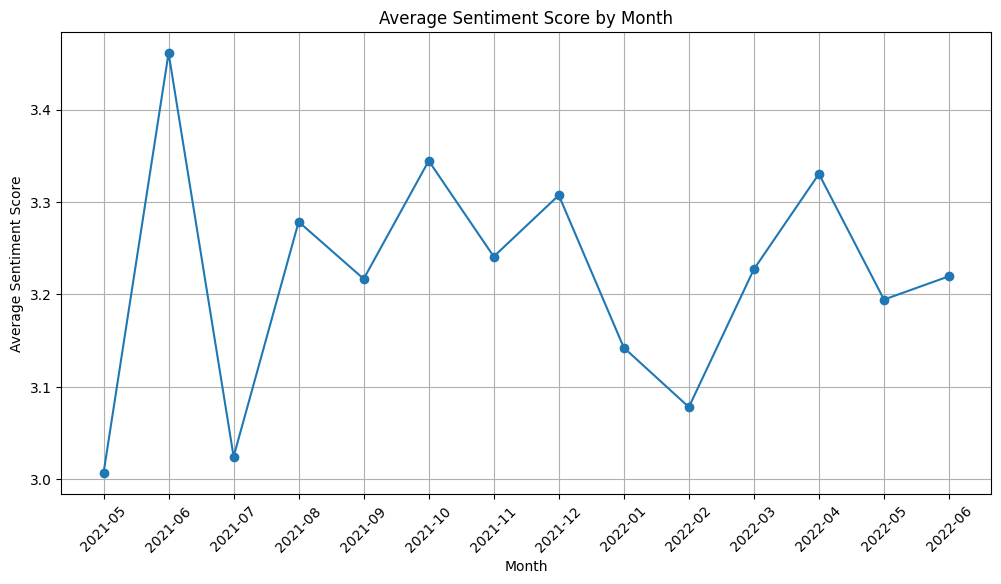

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment, marker='o', linestyle='-')
plt.title("Average Sentiment Score by Month")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.show()

## Plot weekly sentiment score

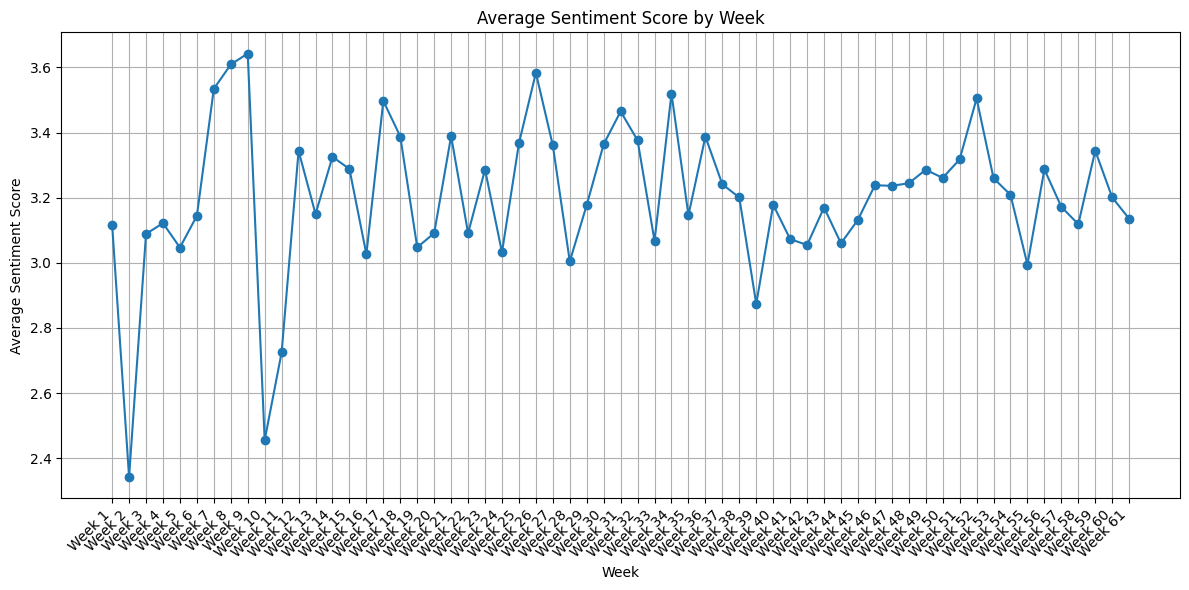

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) build a sequence 1…N
N      = len(weekly_values)
weeks  = np.arange(1, N+1)

# 2) plot against that instead of dates
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weeks, weekly_values, marker='o', linestyle='-')

ax.set_title("Average Sentiment Score by Week")
ax.set_xlabel("Week")
ax.set_ylabel("Average Sentiment Score")
ax.grid(True)

# 3) turn those numeric ticks into "Week 1", "Week 2", …
#    (you can subsample them if you still want fewer labels)
labels = [f"Week {w}" for w in weeks]
ax.set_xticks(weeks)           # place a tick at every integer
ax.set_xticklabels(labels,     # rename them
                   rotation=45,
                   ha="right")

plt.tight_layout()
plt.show()

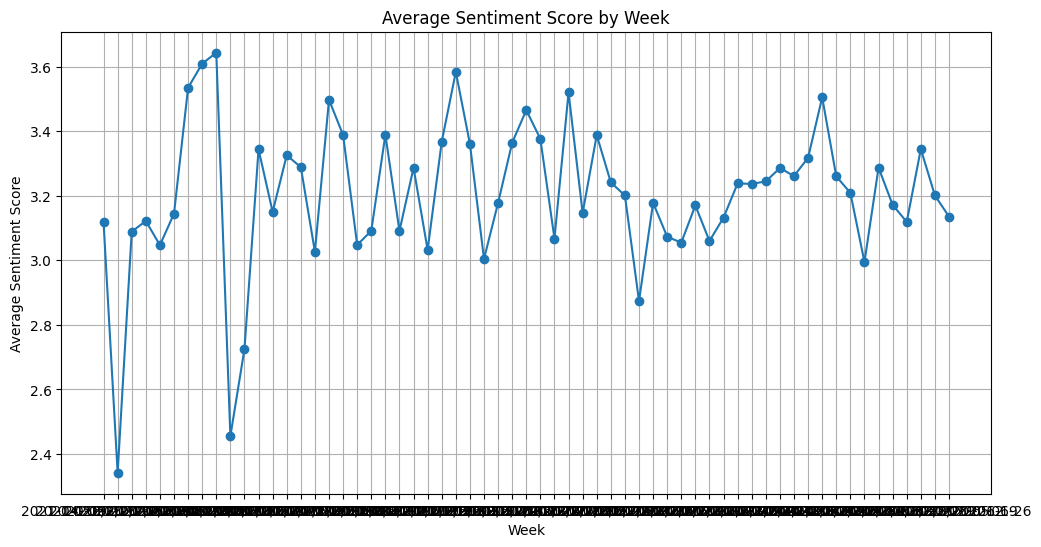

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_indexes, weekly_values, marker='o', linestyle='-')
plt.title("Average Sentiment Score by Week")
plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.show()

# Part 3 - Topic Modeling

<ipython-input-19-11c38b67ac5a>:18: DtypeWarning: Columns (37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv("df_with_sentiment.csv")


Number of tweets for topic modeling: 28049


2025-04-22 13:05:57,847 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/877 [00:00<?, ?it/s]

2025-04-22 14:19:29,648 - BERTopic - Embedding - Completed ✓
2025-04-22 14:19:29,649 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 14:20:51,711 - BERTopic - Dimensionality - Completed ✓
2025-04-22 14:20:51,715 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 14:33:00,271 - BERTopic - Cluster - Completed ✓
2025-04-22 14:33:00,273 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-22 14:33:01,397 - BERTopic - Representation - Completed ✓
2025-04-22 14:33:01,399 - BERTopic - Topic reduction - Reducing number of topics
2025-04-22 14:33:02,180 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 14:33:02,860 - BERTopic - Representation - Completed ✓
2025-04-22 14:33:02,867 - BERTopic - Topic reduction - Reduced number of topics from 458 to 157


   Topic  Count                                           Name  \
0     -1  10924              -1_mali_malienne_transition_junte   
1      0  12184                0_président_colonel_chef_assimi   
2      1    184                        1_mois_durée_24_compter   
3      2    158  2_manifestation_soutien_manifestantion_slogan   
4      3    157         3_embarqués_phénomènes_enclume_marteau   
5      4    112                  4_goïta_assimi_périls_famille   
6      5    106                            5_créa_là_va_elysee   
7      6     90             6_diffusion_rfi_suspension_ordonne   
8      7     81                         7_moctar_ouane_bah_daw   
9      8     75             8_inlassables_otages_libérés_grâce   

                                                                                                     Representation  \
0                                 [mali, malienne, transition, junte, plus, cedeao, maliens, armée, malien, contre]   
1                                [p

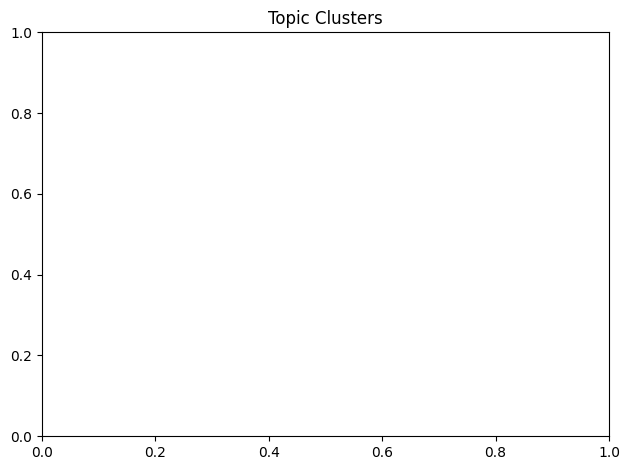

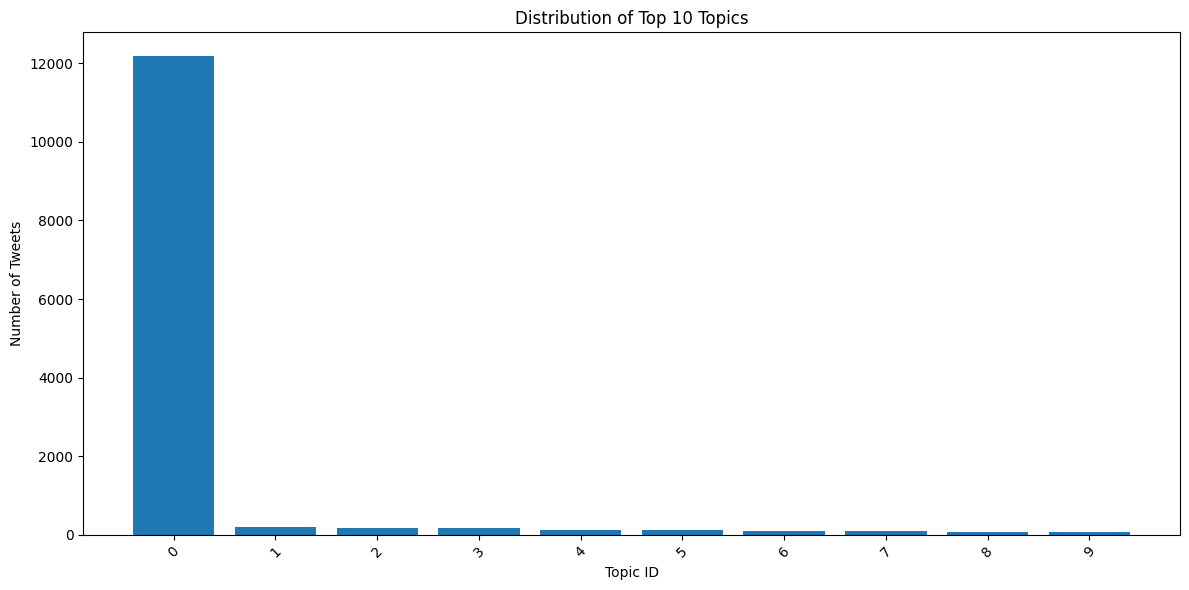

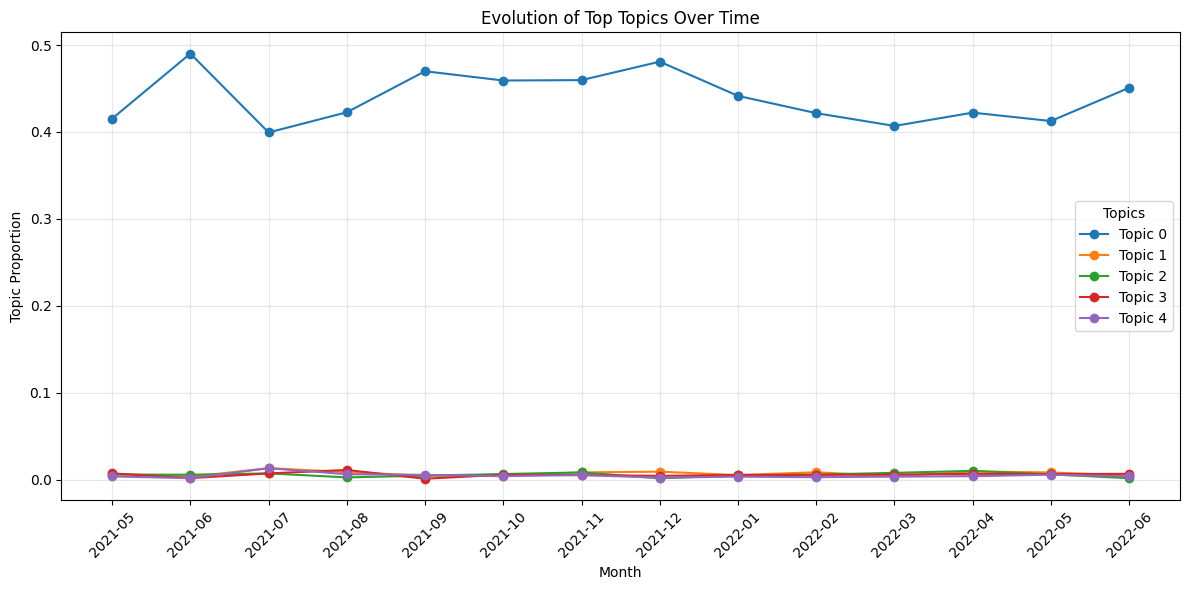

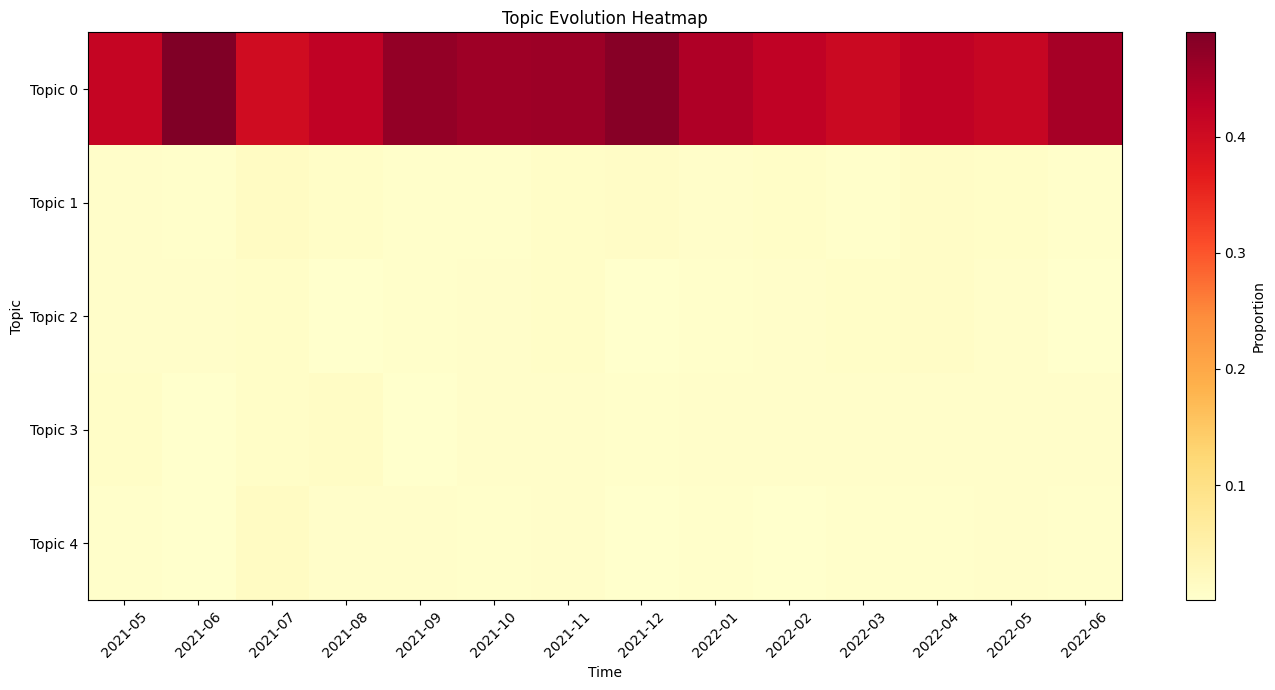

In [ ]:
# Part 3 - Topic Modeling for Mali Twitter Data
!pip install bertopic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
from nltk.corpus import stopwords

# Load the cleaned dataframe
# Assuming df_cleaned is already loaded or:
df_cleaned = pd.read_csv("df_with_sentiment.csv")

# Download NLTK resources if needed
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Prepare French stopwords
french_stopwords = set(stopwords.words('french'))
# Add custom stopwords relevant to your context
custom_stopwords = {
     "au", "aux", "avec", "ce", "ces", "dans", "de", "des", "du", "elle", "en", "et", "eux",
    "il", "je", "la", "le", "leur", "lui", "ma", "mais", "me", "même", "mes", "moi", "mon",
    "ne", "nos", "notre", "nous", "on", "ou", "par", "pas", "pour", "qu", "que", "qui", "sa",
    "se", "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu", "un", "une", "vos",
    "votre", "vous", "c", "d", "j", "l", "à", "m", "n", "s", "t", "y", "été", "étée", "étées",
    "étés", "étant", "suis", "es", "est", "sommes", "êtes", "sont", "serai", "seras", "sera",
    "serons", "serez", "seront", "serais", "serait", "serions", "seriez", "seraient", "étais",
    "était", "étions", "étiez", "étaient", "fus", "fut", "fûmes", "fûtes", "furent", "sois",
    "soit", "soyons", "soyez", "soient", "fusse", "fusses", "fût", "fussions", "fussiez",
    "fussent", "ayant", "eu", "eue", "eues", "eus", "ai", "as", "avons", "avez", "ont", "aurai",
    "auras", "aura", "aurons", "aurez", "auront", "aurais", "aurait", "aurions", "auriez",
    "auraient", "avais", "avait", "avions", "aviez", "avaient", "eut", "eûmes", "eûtes",
    "eurent", "aie", "aies", "ait", "ayons", "ayez", "aient", "eusse", "eusses", "eût",
    "eussions", "eussiez", "eussent", "ceci", "cela", "celà", "cet", "cette", "ici", "ils",
    "les", "leurs", "quel", "quels", "quelle", "quelles", "sans", "soi"
}

all_stopwords = french_stopwords.union(custom_stopwords)

# Ensure we have non-empty cleaned text
df_topic = df_cleaned[df_cleaned['cleaned_text'].notna() & (df_cleaned['cleaned_text'] != '')].copy()
texts = df_topic['cleaned_text'].tolist()

print(f"Number of tweets for topic modeling: {len(texts)}")

# Using a multilingual model since we're working with French tweets
# You can use "paraphrase-multilingual-MiniLM-L12-v2" for a smaller model
embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

# Create UMAP and HDBSCAN instances
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Set up the vectorizer with French stopwords
vectorizer = CountVectorizer(stop_words=list(all_stopwords), max_features=10000)

# Create the BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    language="french",
    verbose=True,
    calculate_probabilities=True,  # Set to True for more detailed but slower analysis
    nr_topics="auto"  # Let the model decide the number of topics
)

# Fit the model to the tweets
topics, probs = topic_model.fit_transform(texts)

# Add topics to the dataframe
df_topic['topic'] = topics

# Get topic information
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# Display the top 10 topics (excluding the -1 topic which contains outliers)
print("\nTop 10 Topics:")
for topic in topic_info[topic_info['Topic'] != -1]['Topic'][:10]:
    print(f"Topic {topic}: {', '.join([word for word, _ in topic_model.get_topic(topic)])}")

# Save topic information
topic_info.to_csv("topic_info.csv", index=False)
df_topic[['tweetId', 'topic']].to_csv("tweet_topics.csv", index=False)

# Visualize topic clusters
fig = topic_model.visualize_topics()
plt.title("Topic Clusters")
plt.tight_layout()
plt.savefig("topic_clusters.png", dpi=300, bbox_inches="tight")

# Visualize topic distribution
topic_counts = df_topic['topic'].value_counts()
topic_counts = topic_counts[topic_counts.index != -1]  # Exclude the outlier topic
topic_counts = topic_counts.sort_values(ascending=False)[:10]  # Top 10 topics

plt.figure(figsize=(12, 6))
bars = plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.xlabel('Topic ID')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Top 10 Topics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("topic_distribution.png", dpi=300, bbox_inches="tight")

# Check for temporal patterns in topics
# Convert date column to datetime
df_topic['createdAtDateTweet'] = pd.to_datetime(df_topic['createdAtDateTweet'])
df_topic['month'] = df_topic['createdAtDateTweet'].dt.to_period('M')

# Calculate topic prevalence over time (monthly)
topic_time = df_topic.groupby(['month', 'topic']).size().unstack().fillna(0)

# Select top 5 topics (excluding -1)
top_topics = [t for t in topic_counts.index[:5] if t != -1]
if len(top_topics) < 5:  # If not enough topics after excluding -1
    top_topics = [t for t in topic_counts.index[:6] if t != -1][:5]

# Plot topic evolution over time
plt.figure(figsize=(12, 6))
for topic in top_topics:
    if topic in topic_time.columns:
        # Normalize to show percentage
        plt.plot(topic_time.index.astype(str),
                 topic_time[topic] / topic_time.sum(axis=1),
                 marker='o',
                 label=f"Topic {topic}")

plt.xlabel('Month')
plt.ylabel('Topic Proportion')
plt.title('Evolution of Top Topics Over Time')
plt.legend(title="Topics")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("topic_evolution.png", dpi=300, bbox_inches="tight")

# Create a heatmap of topic evolution
plt.figure(figsize=(14, 7))
topic_time_norm = topic_time.div(topic_time.sum(axis=1), axis=0)  # Normalize by row
topic_cols = [col for col in topic_time_norm.columns if col in top_topics]
heatmap_data = topic_time_norm[topic_cols]

plt.imshow(heatmap_data.T, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Proportion')
plt.xlabel('Time')
plt.ylabel('Topic')
plt.title('Topic Evolution Heatmap')
plt.yticks(range(len(topic_cols)), [f"Topic {t}" for t in topic_cols])
plt.xticks(range(len(topic_time_norm.index)), topic_time_norm.index.astype(str), rotation=45)
plt.tight_layout()
plt.savefig("topic_heatmap.png", dpi=300, bbox_inches="tight")

print("\nTopic modeling completed!")

## Part 4 - Event Overlay

<ipython-input-20-8229342f8832>:13: DtypeWarning:

Columns (37,38) have mixed types. Specify dtype option on import or set low_memory=False.



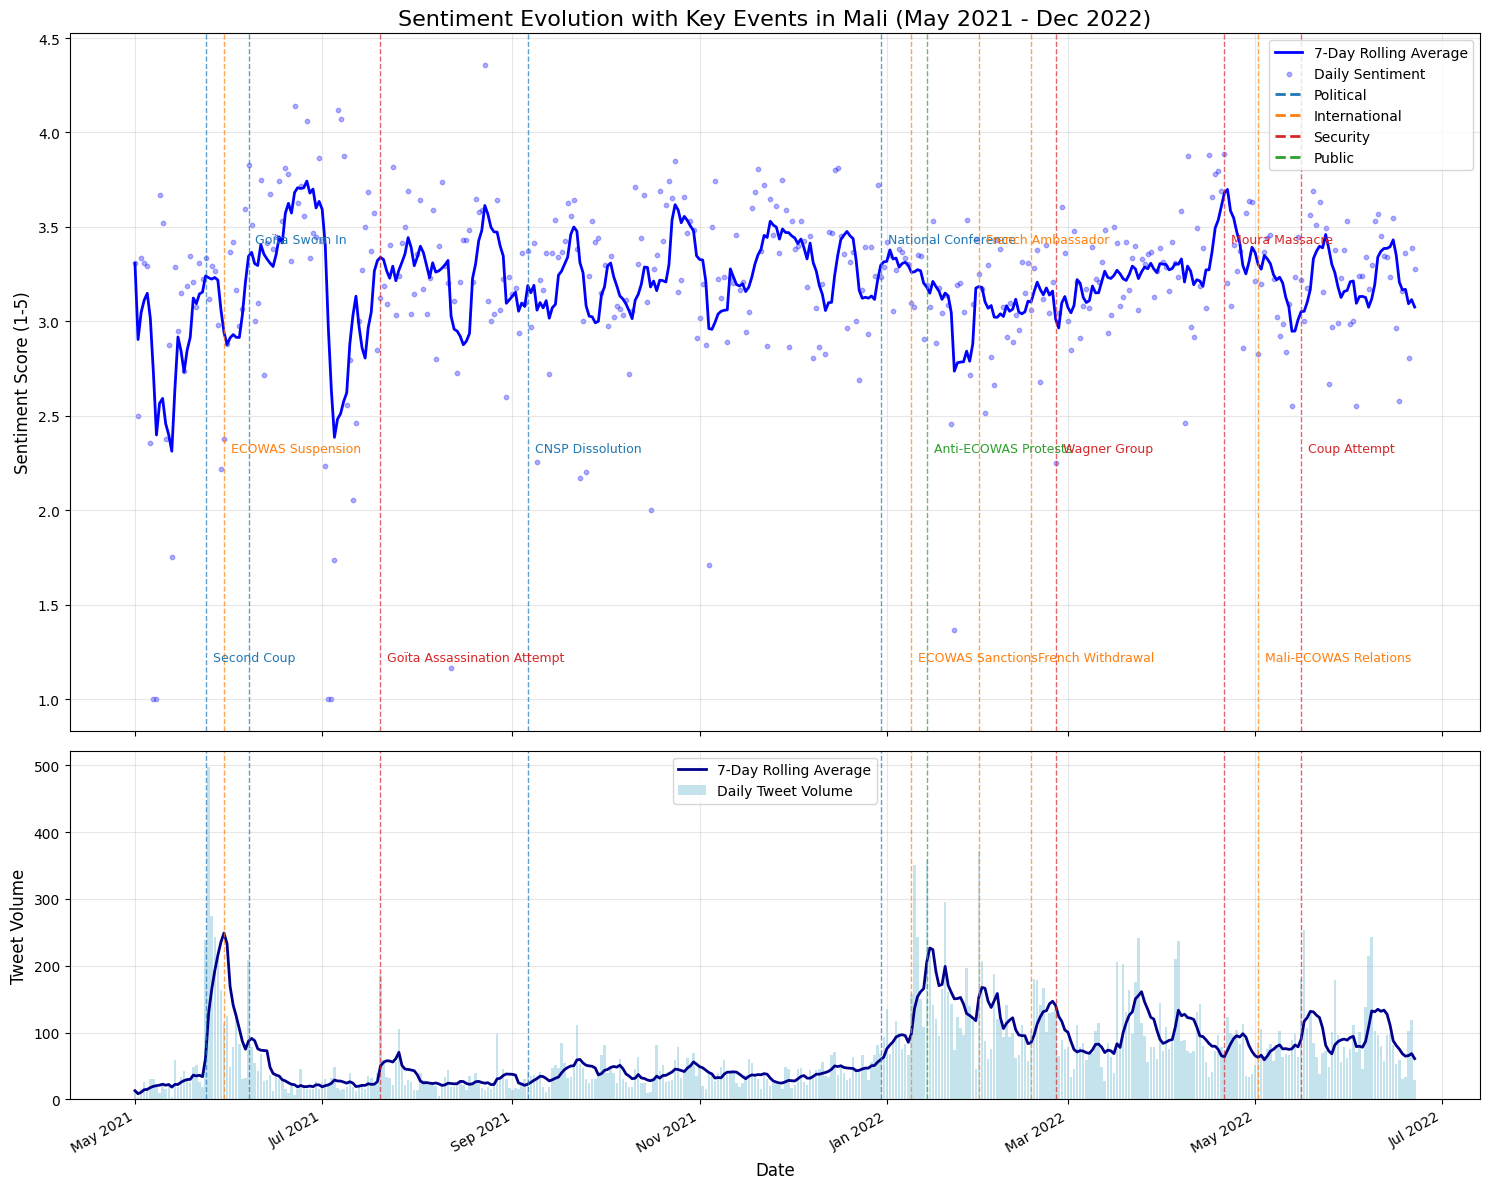

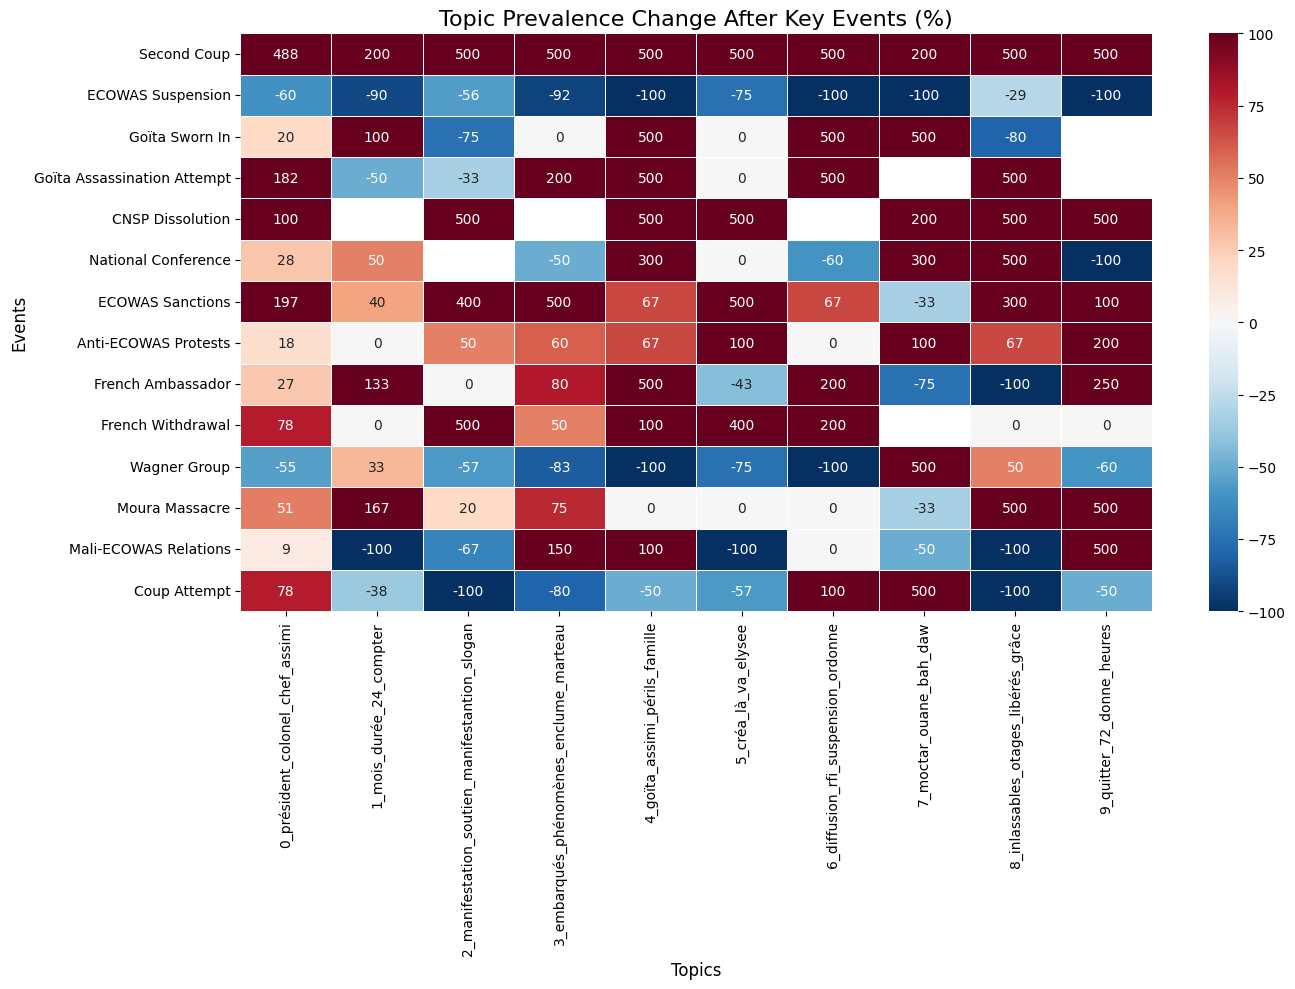

Event overlay analysis completed!
Event sentiment analysis saved to event_sentiment_analysis.csv


In [ ]:
# Part 4 - Event Overlay Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime, timedelta
import json

# Load the sentiment data and topic data
# Assuming these files are already generated from previous steps
df_sentiment = pd.read_csv("df_with_sentiment.csv")
df_topics = pd.read_csv("tweet_topics.csv")

# Merge with topic data if needed
df = df_sentiment.copy()
if 'topic' not in df.columns:
    df = df.merge(df_topics, on='tweetId', how='left')

# Ensure date column is in datetime format
df['createdAtDateTweet'] = pd.to_datetime(df['createdAtDateTweet'])

# Create a mapping from star ratings to numeric sentiment scores
star_mapping = {
    "1 star": 1,
    "2 stars": 2,
    "3 stars": 3,
    "4 stars": 4,
    "5 stars": 5
}
df["sentiment_score"] = df["sentiment"].map(star_mapping)

# Aggregate sentiment by day
daily_sentiment = df.groupby(df['createdAtDateTweet'].dt.date)['sentiment_score'].mean().reset_index()
daily_sentiment['createdAtDateTweet'] = pd.to_datetime(daily_sentiment['createdAtDateTweet'])

# Calculate 7-day rolling average for smoother trend line
daily_sentiment['sentiment_rolling_avg'] = daily_sentiment['sentiment_score'].rolling(window=7, min_periods=1).mean()

# Define key events in Mali after the May 2021 coup
# Format: date, event name, event description, event category
mali_events = [
    # 2021 events
    ('2021-05-24', 'Second Coup', 'Colonel Assimi Goïta seizes power in second coup', 'Political'),
    ('2021-05-30', 'ECOWAS Suspension', 'Mali suspended from ECOWAS', 'International'),
    ('2021-06-07', 'Goïta Sworn In', 'Assimi Goïta sworn in as transitional president', 'Political'),
    ('2021-07-20', 'Goïta Assassination Attempt', 'Failed assassination attempt on Goïta', 'Security'),
    ('2021-09-06', 'CNSP Dissolution', 'Dissolution of the CNSP military junta', 'Political'),
    ('2021-12-30', 'National Conference', 'National conference on reform starts', 'Political'),

    # 2022 events
    ('2022-01-09', 'ECOWAS Sanctions', 'ECOWAS imposes sanctions', 'International'),
    ('2022-01-14', 'Anti-ECOWAS Protests', 'Mass protests against ECOWAS sanctions', 'Public'),
    ('2022-01-31', 'French Ambassador', 'Mali expels French ambassador', 'International'),
    ('2022-02-17', 'French Withdrawal', 'France announces troop withdrawal from Mali', 'International'),
    ('2022-02-25', 'Wagner Group', 'First confirmed Wagner Group presence in Mali', 'Security'),
    ('2022-04-21', 'Moura Massacre', 'Alleged massacre in Moura village involving Malian forces', 'Security'),
    ('2022-05-02', 'Mali-ECOWAS Relations', 'Mali withdraws from G5 Sahel', 'International'),
    ('2022-05-16', 'Coup Attempt', 'Mali claims it foiled a coup attempt', 'Security'),

]

# Convert to DataFrame for easier handling
events_df = pd.DataFrame(mali_events, columns=['date', 'title', 'description', 'category'])
events_df['date'] = pd.to_datetime(events_df['date'])

# Create event categories for color-coding
category_colors = {
    'Political': '#1f77b4',    # Blue
    'International': '#ff7f0e', # Orange
    'Security': '#d62728',      # Red
    'Public': '#2ca02c',        # Green
    'Media': '#9467bd'          # Purple
}

# Create a figure with two subplots (one for sentiment, one for tweet volume)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot sentiment over time
ax1.plot(daily_sentiment['createdAtDateTweet'], daily_sentiment['sentiment_rolling_avg'],
         color='blue', linewidth=2, label='7-Day Rolling Average')
ax1.scatter(daily_sentiment['createdAtDateTweet'], daily_sentiment['sentiment_score'],
            color='blue', alpha=0.3, s=10, label='Daily Sentiment')

# Calculate tweet volume by day
tweet_volume = df.groupby(df['createdAtDateTweet'].dt.date).size().reset_index(name='volume')
tweet_volume['createdAtDateTweet'] = pd.to_datetime(tweet_volume['createdAtDateTweet'])
tweet_volume['volume_rolling_avg'] = tweet_volume['volume'].rolling(window=7, min_periods=1).mean()

# Plot tweet volume
ax2.bar(tweet_volume['createdAtDateTweet'], tweet_volume['volume'],
        color='lightblue', alpha=0.7, label='Daily Tweet Volume')
ax2.plot(tweet_volume['createdAtDateTweet'], tweet_volume['volume_rolling_avg'],
         color='darkblue', linewidth=2, label='7-Day Rolling Average')

# Get y-axis limits for both plots to determine annotation placement
sent_ymin, sent_ymax = ax1.get_ylim()
vol_ymin, vol_ymax = ax2.get_ylim()

# Add event markers and annotations to both plots
event_handles = []  # For legend
used_categories = set()

for _, event in events_df.iterrows():
    # Add vertical line for the event across both plots
    line1 = ax1.axvline(x=event['date'], color=category_colors[event['category']],
                       linestyle='--', alpha=0.7, linewidth=1)
    ax2.axvline(x=event['date'], color=category_colors[event['category']],
                linestyle='--', alpha=0.7, linewidth=1)

    # Add the category to legend only once
    if event['category'] not in used_categories:
        event_handles.append(line1)
        used_categories.add(event['category'])

    # Alternate annotation positions to avoid overcrowding
    idx = events_df.index.get_loc(event.name)
    y_pos = sent_ymin + (sent_ymax - sent_ymin) * (0.1 + (idx % 3) * 0.3)

    # Add text annotation (shortened for clarity)
    ax1.annotate(event['title'],
                xy=(event['date'], y_pos),
                xytext=(5, 0), textcoords='offset points',
                fontsize=9, rotation=0, color=category_colors[event['category']])

# Formatting the plots
ax1.set_title('Sentiment Evolution with Key Events in Mali (May 2021 - Dec 2022)', fontsize=16)
ax1.set_ylabel('Sentiment Score (1-5)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Tweet Volume', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Add legend for event categories
category_patches = [plt.Line2D([0], [0], color=color, lw=2, linestyle='--', label=cat)
                   for cat, color in category_colors.items() if cat in used_categories]
# Get existing legend handles
handles, labels = ax1.get_legend_handles_labels()
# Combine existing and new handles
ax1.legend(handles=handles + category_patches,
          loc='upper right', fontsize=10)

# Format x-axis to show months
plt.gcf().autofmt_xdate()
date_format = mdates.DateFormatter('%b %Y')
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.tight_layout()
plt.savefig("sentiment_with_events.png", dpi=300, bbox_inches="tight")
plt.show()

# Create a heatmap connecting topics and events
# First, let's calculate topic prevalence around each event

# Load topic model info (if available)
try:
    topic_info = pd.read_csv("topic_info.csv")
    topic_dict = {}
    for _, row in topic_info.iterrows():
        if row['Topic'] != -1:  # Skip outlier topic
            topic_dict[row['Topic']] = row['Name']
except:
    # If topic info isn't available, create generic names
    unique_topics = df['topic'].dropna().unique()
    topic_dict = {t: f"Topic {t}" for t in unique_topics if t != -1}

# For each event, calculate topic prevalence in the 7 days before and after
event_topic_data = []

for _, event in events_df.iterrows():
    event_date = event['date']
    before_period = (event_date - timedelta(days=7), event_date)
    after_period = (event_date, event_date + timedelta(days=7))

    # Filter tweets within these periods
    before_tweets = df[(df['createdAtDateTweet'] >= before_period[0]) &
                      (df['createdAtDateTweet'] < before_period[1])]
    after_tweets = df[(df['createdAtDateTweet'] >= after_period[0]) &
                     (df['createdAtDateTweet'] < after_period[1])]

    # Calculate topic distributions
    if 'topic' in df.columns:
        before_topic_counts = before_tweets['topic'].value_counts().to_dict()
        after_topic_counts = after_tweets['topic'].value_counts().to_dict()

        # Calculate percentage change for each topic
        all_topics = set(list(before_topic_counts.keys()) + list(after_topic_counts.keys()))
        for topic in all_topics:
            if topic != -1:  # Skip outlier topic
                before_count = before_topic_counts.get(topic, 0)
                after_count = after_topic_counts.get(topic, 0)

                if before_count > 0:
                    pct_change = (after_count - before_count) / before_count * 100
                else:
                    pct_change = float('inf') if after_count > 0 else 0

                event_topic_data.append({
                    'event_date': event_date,
                    'event_title': event['title'],
                    'topic': topic,
                    'topic_name': topic_dict.get(topic, f"Topic {topic}"),
                    'before_count': before_count,
                    'after_count': after_count,
                    'percent_change': min(pct_change, 500)  # Cap at 500% for visualization
                })

# Convert to DataFrame
if event_topic_data:
    event_topic_df = pd.DataFrame(event_topic_data)

    # Filter to the top 10 topics by overall volume
    top_topics = df['topic'].value_counts().drop(-1, errors='ignore').nlargest(10).index.tolist()
    event_topic_filtered = event_topic_df[event_topic_df['topic'].isin(top_topics)]

    # Pivot the data for the heatmap
    pivot_data = event_topic_filtered.pivot(index='event_title', columns='topic_name', values='percent_change')

    # Sort events chronologically
    event_order = events_df['title'].tolist()
    pivot_data = pivot_data.reindex(event_order)

    # Create heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_data, cmap='RdBu_r', center=0,
                vmin=-100, vmax=100,
                annot=True, fmt='.0f', linewidths=.5)
    plt.title('Topic Prevalence Change After Key Events (%)', fontsize=16)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Events', fontsize=12)
    plt.tight_layout()
    plt.savefig("event_topic_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Create a detailed event-sentiment analysis table
    event_sentiment = []
    for _, event in events_df.iterrows():
        event_date = event['date']
        # 7 days before
        before_period = (event_date - timedelta(days=7), event_date)
        # 7 days after
        after_period = (event_date, event_date + timedelta(days=7))

        # Get average sentiment before and after
        before_sent = df[(df['createdAtDateTweet'] >= before_period[0]) &
                      (df['createdAtDateTweet'] < before_period[1])]['sentiment_score'].mean()
        after_sent = df[(df['createdAtDateTweet'] >= after_period[0]) &
                     (df['createdAtDateTweet'] < after_period[1])]['sentiment_score'].mean()

        # Calculate change
        sentiment_change = after_sent - before_sent

        # Calculate tweet volume before and after
        before_vol = len(df[(df['createdAtDateTweet'] >= before_period[0]) &
                          (df['createdAtDateTweet'] < before_period[1])])
        after_vol = len(df[(df['createdAtDateTweet'] >= after_period[0]) &
                         (df['createdAtDateTweet'] < after_period[1])])
        volume_change_pct = ((after_vol - before_vol) / before_vol * 100) if before_vol > 0 else 0

        event_sentiment.append({
            'Date': event_date.strftime('%Y-%m-%d'),
            'Event': event['title'],
            'Category': event['category'],
            'Sentiment Before': round(before_sent, 2),
            'Sentiment After': round(after_sent, 2),
            'Sentiment Change': round(sentiment_change, 2),
            'Volume Before': before_vol,
            'Volume After': after_vol,
            'Volume Change %': round(volume_change_pct, 1)
        })

    # Convert to DataFrame and save
    event_sentiment_df = pd.DataFrame(event_sentiment)
    event_sentiment_df.to_csv("event_sentiment_analysis.csv", index=False)

    print("Event overlay analysis completed!")
    print(f"Event sentiment analysis saved to event_sentiment_analysis.csv")
else:
    print("No topic data available for event-topic analysis.")
    # Still create the event-sentiment analysis
    # [Code similar to above]

## Part 5 - Stance Classification

In [ ]:
import pandas as pd
import requests
import time
import glob
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import argparse

# Configuration for distributed processing
START_CHUNK = 17  # Start from chunk 17
END_CHUNK = None  # Process until the end (None) or specify a limit

# Ollama configuration
OLLAMA_API_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "mistral-instruct-fr"  # Recommended model for French political content

def create_stance_prompt(tweet_text):
    """Create a well-designed prompt for stance classification with improved context"""
    return f"""You are a political analyst specialized in West African geopolitics and online discourse.

Your task is to classify tweets about the Malian military junta into one of three categories:
- pro-junta: supportive of the junta, Colonel Assimi Goïta, or the military's actions
- anti-junta: critical of the junta, its actions, leadership, or impact on democracy/stability
- neutral: fact-reporting or unrelated content with no discernible stance

🧠 Consider both direct and indirect expressions:
- Support can be implied by praise of the army, criticism of ECOWAS/France, or defending the military.
- Opposition may appear via sarcasm, irony, or expressions of concern over repression or instability.

🌍 Political context:
- Mali experienced multiple coups and deteriorating relations with France, ECOWAS, and the UN.
- Some citizens support the junta for resisting foreign influence or ensuring security.

🧪 Examples:
1. "Assimi Goïta est un héros, il a libéré le Mali des mains de l'élite corrompue." → pro-junta
2. "Le peuple malien mérite mieux qu'un régime militaire." → anti-junta
3. "Le président par intérim du Mali a rencontré des diplomates russes aujourd'hui." → neutral

Be careful with metaphor, rhetorical questions, or sarcastic tone.
Your answer must only be one of:
- pro-junta
- anti-junta
- neutral

Also explain the classification in 1 sentence.

Tweet: "{tweet_text}"

Classification (only respond with "pro-junta", "anti-junta", or "neutral" and a brief explanation):"""

def query_ollama(prompt):
    """Send a query to Ollama's local API"""
    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False
    }

    response = requests.post(OLLAMA_API_URL, json=payload)
    if response.status_code == 200:
        return response.json()["response"]
    else:
        raise Exception(f"Error: {response.status_code}, {response.text}")

def extract_stance_from_response(response_text):
    """Extract the stance label from the model's response"""
    response_text = response_text.lower()

    if "pro-junta" in response_text.split():
        return "pro-junta"
    elif "anti-junta" in response_text.split():
        return "anti-junta"
    elif "neutral" in response_text.split():
        return "neutral"
    else:
        # If none of the expected labels are found, try to infer from the explanation
        if any(term in response_text for term in ["support", "positive", "favor", "defend"]):
            return "pro-junta"
        elif any(term in response_text for term in ["critic", "negative", "against", "oppose"]):
            return "anti-junta"
        else:
            return "neutral"

def process_tweets_in_batches(df, batch_size=20):
    """Process tweets in batches for efficiency"""
    results = []

    # Create a tqdm progress bar
    with tqdm(total=len(df), desc="Processing tweets") as pbar:
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i+batch_size]

            batch_results = []
            for _, row in batch.iterrows():
                tweet_text = row['cleaned_text']

                # Skip empty or NaN tweets
                if pd.isna(tweet_text) or tweet_text.strip() == '':
                    batch_results.append({
                        "tweet_id": row['tweetId'],
                        "stance": "neutral",  # Default to neutral for empty tweets
                        "explanation": "Empty tweet",
                        "confidence": 0.0
                    })
                    pbar.update(1)
                    continue

                prompt = create_stance_prompt(tweet_text)

                # Local Ollama call with retry mechanism
                for attempt in range(3):
                    try:
                        result = query_ollama(prompt)

                        # Extract stance label
                        stance = extract_stance_from_response(result)

                        batch_results.append({
                            "tweet_id": row['tweetId'],
                            "stance": stance,
                            "explanation": result,
                            "confidence": 1.0
                        })
                        break

                    except Exception as e:
                        print(f"Attempt {attempt+1} failed for tweet {row['tweetId']}: {e}")
                        if attempt == 2:
                            print(f"Failed after 3 attempts for tweet {row['tweetId']}")
                            batch_results.append({
                                "tweet_id": row['tweetId'],
                                "stance": "error",
                                "explanation": str(e),
                                "confidence": 0.0
                            })
                        time.sleep(1)  # Brief pause before retry

                pbar.update(1)

            results.extend(batch_results)

            # Save intermediate results every batch
            batch_df = pd.DataFrame(batch_results)
            if not batch_df.empty:
                batch_df.to_csv(f"stance_results/batch_{i}.csv", index=False)

            # No need for long pauses with local model
            time.sleep(0.1)

    return pd.DataFrame(results)

def main():
    # Parse command line arguments for flexibility
    parser = argparse.ArgumentParser(description='Process tweets for stance classification, starting from a specific chunk')
    parser.add_argument('--start-chunk', type=int, default=START_CHUNK, help='First chunk to process (default: 17)')
    parser.add_argument('--end-chunk', type=int, default=None, help='Last chunk to process (default: None, process until end)')
    parser.add_argument('--chunk-size', type=int, default=500, help='Number of tweets per chunk (default: 500)')
    parser.add_argument('--model', type=str, default=MODEL_NAME, help='Ollama model to use')
    args = parser.parse_args()

    global MODEL_NAME
    MODEL_NAME = args.model

    # Check if Ollama is running
    try:
        response = requests.get("http://localhost:11434/api/tags")
        if response.status_code != 200:
            print("Error: Ollama server is not responding properly")
            return

        # Check if the model is available
        models = response.json().get("models", [])
        model_names = [model["name"] for model in models]

        if MODEL_NAME not in model_names:
            print(f"Warning: Model '{MODEL_NAME}' not found in Ollama")
            print(f"Available models: {', '.join(model_names)}")
            print(f"Please run: ollama pull {MODEL_NAME}")
            return

    except requests.exceptions.ConnectionError:
        print("Error: Cannot connect to Ollama server")
        print("Please make sure Ollama is running with: ollama serve")
        return

    # Load the dataset
    print("Loading dataset...")
    try:
        df = pd.read_csv("df_with_sentiment.csv")
    except FileNotFoundError:
        print("Error: Could not find df_with_sentiment.csv")
        print("Please ensure the file exists in the current directory")
        return

    # Ensure we have the required columns
    if 'tweetId' not in df.columns or 'cleaned_text' not in df.columns:
        print("Error: Required columns 'tweetId' or 'cleaned_text' not found in dataset")
        print(f"Available columns: {', '.join(df.columns)}")
        return

    print(f"Dataset loaded with {len(df)} tweets")

    # Create output directory if it doesn't exist
    os.makedirs("stance_results", exist_ok=True)

    # Calculate chunk information
    chunk_size = args.chunk_size
    total_chunks = (len(df) + chunk_size - 1) // chunk_size
    start_chunk = args.start_chunk
    end_chunk = args.end_chunk if args.end_chunk is not None else total_chunks

    print(f"Processing chunks {start_chunk} to {end_chunk} of {total_chunks} total chunks")
    print(f"Each chunk contains {chunk_size} tweets")

    # Process only the specified range of chunks
    for chunk_idx in range(start_chunk, end_chunk):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, len(df))
        chunk = df.iloc[chunk_start:chunk_end].copy()

        print(f"\nProcessing chunk {chunk_idx}/{total_chunks-1} (tweets {chunk_start+1}-{chunk_end})")

        # Skip if this chunk was already processed
        output_file = f"stance_results/chunk_{chunk_start}.csv"
        if os.path.exists(output_file):
            print(f"Chunk results already exist at {output_file}, skipping...")
            continue

        # Process the chunk
        chunk_results = process_tweets_in_batches(chunk, batch_size=20)

        # Save chunk results
        if not chunk_results.empty:
            chunk_results.to_csv(output_file, index=False)
            print(f"Saved results to {output_file}")

        # Provide interim stats on stance distribution
        if not chunk_results.empty:
            print("Interim stance distribution for this chunk:")
            print(chunk_results['stance'].value_counts())

    print("\nCompleted processing all assigned chunks!")
    print("The results are saved in the 'stance_results' directory")
    print("To combine results from all machines, collect all CSV files and run the merge script")

if __name__ == "__main__":
    main()

## Part 6 - Network analysis

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os

# Create directory for outputs
os.makedirs("network_analysis", exist_ok=True)
os.makedirs("network_analysis/plots", exist_ok=True)

print("Loading data...")
# Load network data
edges = pd.read_csv("following_network.csv")

# Load stance data
stance_df = pd.read_csv("mali_tweets_with_stance.csv")

print("Preparing network analysis...")
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in tqdm(edges.iterrows(), total=len(edges), desc="Building network"):
    G.add_edge(row['source'], row['target'])

print(f"Initial network: {len(G.nodes())} nodes, {len(G.edges())} edges")

# Calculate in-degree for each node
in_degrees = dict(G.in_degree())

# Filter out nodes with in-degree of 0
nodes_to_remove = [node for node, degree in in_degrees.items() if degree == 0]
G.remove_nodes_from(nodes_to_remove)

print(f"After filtering: {len(G.nodes())} nodes, {len(G.edges())} edges")
print(f"Removed {len(nodes_to_remove)} nodes with in-degree of 0")

# Basic network metrics
print("\nCalculating network metrics...")
density = nx.density(G)
avg_clustering = nx.average_clustering(G)

# Handle the connectivity issues robustly
num_weakly_connected = nx.number_weakly_connected_components(G)
num_strongly_connected = nx.number_strongly_connected_components(G)

print(f"Network density: {density:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Number of weakly connected components: {num_weakly_connected}")
print(f"Number of strongly connected components: {num_strongly_connected}")

# Find the largest weakly connected component
largest_wcc = max(nx.weakly_connected_components(G), key=len)
G_wcc = G.subgraph(largest_wcc)
print(f"Largest weakly connected component: {len(G_wcc.nodes())} nodes ({len(G_wcc.nodes())/len(G.nodes())*100:.1f}% of network)")

# Find the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)
G_scc = G.subgraph(largest_scc)
print(f"Largest strongly connected component: {len(G_scc.nodes())} nodes ({len(G_scc.nodes())/len(G.nodes())*100:.1f}% of network)")

# Compute degree distributions
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)

# Plot degree distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# In-degree distribution
ax1.hist(in_degree_sequence, bins=50, alpha=0.75, color='blue')
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("In-degree")
ax1.set_ylabel("Count")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Out-degree distribution
ax2.hist(out_degree_sequence, bins=50, alpha=0.75, color='red')
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Out-degree")
ax2.set_ylabel("Count")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("network_analysis/plots/degree_distributions.png", dpi=300)

# Calculate node centralities
print("\nCalculating node centralities...")

# Calculate different centrality measures
centralities = {}
centralities['in_degree'] = dict(G.in_degree())
centralities['out_degree'] = dict(G.out_degree())

print("Calculating betweenness centrality (this may take a while)...")
try:
    centralities['betweenness'] = nx.betweenness_centrality(
        G,
        k=min(500, len(G.nodes())),
        seed=42,
        weight=None
    )  # Sample 500 nodes for approximation
except Exception as e:
    print(f"Could not calculate betweenness centrality: {e}")
    centralities['betweenness'] = {node: 0.0 for node in G.nodes()}

print("Calculating eigenvector centrality...")
try:
    # For large networks, eigenvector centrality might not converge
    # Use power iteration method with more iterations
    centralities['eigenvector'] = nx.eigenvector_centrality(
        G,
        max_iter=1000,
        tol=1e-05
    )
except Exception as e:
    print(f"Could not calculate eigenvector centrality with standard method: {e}")
    try:
        # Fall back to numpy-based method
        centralities['eigenvector'] = nx.eigenvector_centrality_numpy(G)
    except Exception as e:
        print(f"Could not calculate eigenvector centrality with numpy method: {e}")
        centralities['eigenvector'] = {node: 0.0 for node in G.nodes()}

# Prepare a DataFrame for centrality measures
centrality_df = pd.DataFrame(centralities)
centrality_df.index.name = 'user_id'
centrality_df.reset_index(inplace=True)

# Save centralities
centrality_df.to_csv("network_analysis/user_centralities.csv", index=False)

# Identify top influencers
print("\nTop influencers by different centrality measures:")
for measure in ['in_degree', 'eigenvector', 'betweenness']:
    top_users = centrality_df.nlargest(10, measure)[['user_id', measure]]
    print(f"\nTop 10 users by {measure} centrality:")
    print(top_users)

# Process stance data
print("\nProcessing stance data...")
try:
    # Check if we have user ID in the stance data
    if 'userId' in stance_df.columns:
        # Group by user ID directly
        user_stances = stance_df.groupby('userId')['stance'].agg(
            lambda x: x.mode().iloc[0] if len(x) > 0 and not x.isna().all() and len(x.mode()) > 0 else 'unknown'
        ).reset_index().rename(columns={'userId': 'user_id'})

        print(f"Processed stance data for {len(user_stances)} users")
        print(f"Stance distribution: {user_stances['stance'].value_counts().to_dict()}")

        # Save user stances
        user_stances.to_csv("network_analysis/user_stances.csv", index=False)

        # Create a mapping of user_id to stance
        user_stance_map = dict(zip(user_stances['user_id'], user_stances['stance']))

        # Add stance to the graph as node attribute
        for node in G.nodes():
            G.nodes[node]['stance'] = user_stance_map.get(node, 'unknown')

        # Analysis of follow patterns by stance
        print("\nAnalyzing follow patterns by stance...")

        # Create subgroups by stance
        pro_users = set(user_stances[user_stances['stance'] == 'pro-junta']['user_id'])
        anti_users = set(user_stances[user_stances['stance'] == 'anti-junta']['user_id'])
        neutral_users = set(user_stances[user_stances['stance'] == 'neutral']['user_id'])

        print(f"Pro-junta users in the network: {len(pro_users)}")
        print(f"Anti-junta users in the network: {len(anti_users)}")
        print(f"Neutral users in the network: {len(neutral_users)}")

        # Create a subgraph of users with known stances
        stance_known_users = pro_users.union(anti_users).union(neutral_users)
        G_stance = G.subgraph(stance_known_users)

        print(f"Users with known stance in the network: {len(G_stance.nodes())}")

        # For each pro-junta user, calculate share of following other pro/anti users
        follow_patterns = []

        for user in tqdm(pro_users.intersection(G_stance.nodes()), desc="Analyzing pro-junta users"):
            # Get all users this pro-junta user follows
            follows = list(G_stance.successors(user))

            if not follows:
                continue

            # Count by stance
            follows_pro = sum(1 for u in follows if u in pro_users)
            follows_anti = sum(1 for u in follows if u in anti_users)
            follows_neutral = sum(1 for u in follows if u in neutral_users)

            # Calculate percentages
            total_pro_users = len(pro_users) - 1  # exclude self
            total_anti_users = len(anti_users)

            # Percentage of all other pro users followed
            pct_follows_pro = follows_pro / total_pro_users if total_pro_users > 0 else 0

            # Percentage of all anti users followed
            pct_follows_anti = follows_anti / total_anti_users if total_anti_users > 0 else 0

            follow_patterns.append({
                'user_id': user,
                'follows_count': len(follows),
                'follows_pro_count': follows_pro,
                'follows_anti_count': follows_anti,
                'follows_neutral_count': follows_neutral,
                'pct_follows_pro': pct_follows_pro,
                'pct_follows_anti': pct_follows_anti,
                'ratio_pro_anti': follows_pro / follows_anti if follows_anti > 0 else float('inf')
            })

        # Convert to DataFrame
        follow_patterns_df = pd.DataFrame(follow_patterns)

        # Save follow patterns
        follow_patterns_df.to_csv("network_analysis/pro_user_follow_patterns.csv", index=False)

        # Calculate averages
        avg_pct_follows_pro = follow_patterns_df['pct_follows_pro'].mean()
        avg_pct_follows_anti = follow_patterns_df['pct_follows_anti'].mean()

        print(f"\nOn average, a pro-junta user follows {avg_pct_follows_pro:.2%} of all other pro-junta users")
        print(f"On average, a pro-junta user follows {avg_pct_follows_anti:.2%} of all anti-junta users")

        # Plot the distribution of these percentages
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(follow_patterns_df['pct_follows_pro'], bins=20, alpha=0.7, color='red')
        plt.axvline(avg_pct_follows_pro, color='black', linestyle='--', label=f'Mean: {avg_pct_follows_pro:.2%}')
        plt.title("Distribution of % of other pro-junta users followed")
        plt.xlabel("Percentage of pro-junta users followed")
        plt.ylabel("Count")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.hist(follow_patterns_df['pct_follows_anti'], bins=20, alpha=0.7, color='blue')
        plt.axvline(avg_pct_follows_anti, color='black', linestyle='--', label=f'Mean: {avg_pct_follows_anti:.2%}')
        plt.title("Distribution of % of anti-junta users followed")
        plt.xlabel("Percentage of anti-junta users followed")
        plt.ylabel("Count")
        plt.legend()

        plt.tight_layout()
        plt.savefig("network_analysis/plots/follow_pattern_distributions.png", dpi=300)

        # Now calculate the same stats for anti-junta users
        anti_follow_patterns = []

        for user in tqdm(anti_users.intersection(G_stance.nodes()), desc="Analyzing anti-junta users"):
            # Get all users this anti-junta user follows
            follows = list(G_stance.successors(user))

            if not follows:
                continue

            # Count by stance
            follows_pro = sum(1 for u in follows if u in pro_users)
            follows_anti = sum(1 for u in follows if u in anti_users)
            follows_neutral = sum(1 for u in follows if u in neutral_users)

            # Calculate percentages
            total_pro_users = len(pro_users)
            total_anti_users = len(anti_users) - 1  # exclude self

            # Percentage of all pro users followed
            pct_follows_pro = follows_pro / total_pro_users if total_pro_users > 0 else 0

            # Percentage of all other anti users followed
            pct_follows_anti = follows_anti / total_anti_users if total_anti_users > 0 else 0

            anti_follow_patterns.append({
                'user_id': user,
                'follows_count': len(follows),
                'follows_pro_count': follows_pro,
                'follows_anti_count': follows_anti,
                'follows_neutral_count': follows_neutral,
                'pct_follows_pro': pct_follows_pro,
                'pct_follows_anti': pct_follows_anti,
                'ratio_anti_pro': follows_anti / follows_pro if follows_pro > 0 else float('inf')
            })

        # Convert to DataFrame
        anti_follow_patterns_df = pd.DataFrame(anti_follow_patterns)

        # Save follow patterns
        anti_follow_patterns_df.to_csv("network_analysis/anti_user_follow_patterns.csv", index=False)

        # Calculate averages
        avg_anti_pct_follows_pro = anti_follow_patterns_df['pct_follows_pro'].mean()
        avg_anti_pct_follows_anti = anti_follow_patterns_df['pct_follows_anti'].mean()

        print(f"\nOn average, an anti-junta user follows {avg_anti_pct_follows_pro:.2%} of all pro-junta users")
        print(f"On average, an anti-junta user follows {avg_anti_pct_follows_anti:.2%} of all other anti-junta users")

        # Create comparison plot
        plt.figure(figsize=(10, 6))

        # Data for the plot
        categories = ['Same stance', 'Opposite stance']
        pro_values = [avg_pct_follows_pro, avg_pct_follows_anti]
        anti_values = [avg_anti_pct_follows_anti, avg_anti_pct_follows_pro]

        x = np.arange(len(categories))
        width = 0.35

        plt.bar(x - width/2, pro_values, width, label='Pro-junta users', color='red', alpha=0.7)
        plt.bar(x + width/2, anti_values, width, label='Anti-junta users', color='blue', alpha=0.7)

        plt.xlabel('Follow Target')
        plt.ylabel('Average percentage followed')
        plt.title('Echo Chamber Effect: Following Patterns by Political Stance')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add value labels on the bars
        for i, v in enumerate(pro_values):
            plt.text(i - width/2, v + 0.01, f'{v:.1%}', ha='center')

        for i, v in enumerate(anti_values):
            plt.text(i + width/2, v + 0.01, f'{v:.1%}', ha='center')

        plt.tight_layout()
        plt.savefig("network_analysis/plots/stance_follow_comparison.png", dpi=300)

        # Homophily index calculation
        # Formula: (% following same stance - % following opposite stance) / (% following same stance + % following opposite stance)
        pro_homophily = (avg_pct_follows_pro - avg_pct_follows_anti) / (avg_pct_follows_pro + avg_pct_follows_anti) if (avg_pct_follows_pro + avg_pct_follows_anti) > 0 else 0
        anti_homophily = (avg_anti_pct_follows_anti - avg_anti_pct_follows_pro) / (avg_anti_pct_follows_anti + avg_anti_pct_follows_pro) if (avg_anti_pct_follows_anti + avg_anti_pct_follows_pro) > 0 else 0

        print(f"\nHomophily index for pro-junta users: {pro_homophily:.4f}")
        print(f"Homophily index for anti-junta users: {anti_homophily:.4f}")

        # Create a summary dataframe
        summary_data = {
            'Metric': [
                'Pro-junta users count',
                'Anti-junta users count',
                'Avg % of same-stance users followed (pro)',
                'Avg % of opposite-stance users followed (pro)',
                'Avg % of same-stance users followed (anti)',
                'Avg % of opposite-stance users followed (anti)',
                'Homophily index (pro)',
                'Homophily index (anti)'
            ],
            'Value': [
                len(pro_users),
                len(anti_users),
                avg_pct_follows_pro,
                avg_pct_follows_anti,
                avg_anti_pct_follows_anti,
                avg_anti_pct_follows_pro,
                pro_homophily,
                anti_homophily
            ]
        }

        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv("network_analysis/echo_chamber_summary.csv", index=False)

    else:
        print("Warning: No userId column found in stance data. Skipping stance-based analysis.")

except Exception as e:
    print(f"Error in stance analysis: {e}")
    print("Skipping stance-based analysis due to errors.")

# Create a visualization of the network with stance information
print("\nCreating network visualization...")
try:
    # Create a more manageable subgraph for visualization
    # Select users with highest in-degree centrality
    top_users = set(centrality_df.nlargest(200, 'in_degree')['user_id'])

    # Create subgraph
    G_viz = G.subgraph(top_users)

    # Prepare node colors based on stance if available
    if 'user_stance_map' in locals():
        # Color scheme
        stance_colors = {
            'pro-junta': 'red',
            'anti-junta': 'blue',
            'neutral': 'gray',
            'unknown': 'lightgray'
        }

        node_colors = [stance_colors.get(user_stance_map.get(node, 'unknown'), 'lightgray') for node in G_viz.nodes()]

        # Create stance legend patches
        stance_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=stance)
                         for stance, color in stance_colors.items()]
    else:
        # Default coloring if stance data not available
        node_colors = ['lightgray'] * len(G_viz.nodes())
        stance_patches = []

    # Calculate layout
    pos = nx.spring_layout(G_viz, seed=42, k=0.3, iterations=100)

    # Create the visualization
    plt.figure(figsize=(12, 12))

    # Draw edges with low alpha
    nx.draw_networkx_edges(G_viz, pos, alpha=0.2, arrows=True)

    # Node sizes based on in-degree
    node_sizes = [20 + 5 * G.in_degree(node) for node in G_viz.nodes()]

    # Draw nodes
    nx.draw_networkx_nodes(G_viz, pos, node_color=node_colors, node_size=node_sizes, alpha=0.7)

    # Add legend if stance data is available
    if stance_patches:
        plt.legend(handles=stance_patches, title="User Stance", loc='upper right')

    plt.title("Mali Twitter Follower Network - Top 200 Users by In-degree")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("network_analysis/plots/network_visualization.png", dpi=300)

except Exception as e:
    print(f"Error in network visualization: {e}")
    print("Skipping network visualization due to errors.")

print("\nNetwork analysis complete. Results saved to the 'network_analysis' directory.")

# Validation

In [3]:
# https://docs.google.com/spreadsheets/d/131roO9pOcWlXy5GCnIENPtzrGr-pgRHhJTzfsPoj0k4/edit?usp=sharing

In [4]:
# !gdown 131roO9pOcWlXy5GCnIENPtzrGr-pgRHhJTzfsPoj0k4

Downloading...
From (original): https://drive.google.com/uc?id=131roO9pOcWlXy5GCnIENPtzrGr-pgRHhJTzfsPoj0k4
From (redirected): https://docs.google.com/spreadsheets/d/131roO9pOcWlXy5GCnIENPtzrGr-pgRHhJTzfsPoj0k4/export?format=xlsx
To: /content/mali_tweets_with_stance.xlsx
10.8MB [00:00, 38.2MB/s]


In [ ]:
# https://docs.google.com/spreadsheets/d/1eFxLnBEiHV_xgBe1oeBSthqNg9XX5qwRHAaX2V3dNQE/edit?usp=sharing

In [6]:
# !gdown 1eFxLnBEiHV_xgBe1oeBSthqNg9XX5qwRHAaX2V3dNQE

In [23]:
mistral_labells = pd.read_excel("mali_tweets_with_stance.xlsx", usecols = ["tweetId", "stance"])

In [24]:
mistral_labells.head(5)

,tweetId,stance
0,1530365845968412672,pro-junta
1,1445531608165982208,pro-junta
2,1494713848565223428,pro-junta
3,1400276189533642757,pro-junta
4,1511502065595740160,pro-junta


In [25]:
hand_labells = pd.read_excel("tweets_to_label.xlsx", usecols = ["tweetId", "stance"])

In [26]:
hand_labells.head(5)

,tweetId,stance
0,1397859500518948866,anti-junta
1,1402008365182636036,neutral
2,1513521036884684802,neutral
3,1401499128199266305,neutral
4,1460674156899536903,neutral


In [37]:
validation = pd.merge(mistral_labells, hand_labells, on='tweetId', how='inner')

In [38]:
validation

,tweetId,stance_x,stance_y
0,1397917073460789266,pro-junta,anti-junta
1,1446282419640885250,neutral,neutral
2,1530172548071178242,pro-junta,anti-junta
3,1505903394157912069,pro-junta,neutral
4,1488282683247833088,neutral,pro-junta
...,...,...,...
493,1494984435401474049,pro-junta,neutral
494,1511332597238009857,pro-junta,anti-junta
495,1417480013692157958,neutral,neutral
496,1527179774761881600,neutral,neutral


In [39]:
validation.rename(columns={'stance_x': 'mistral_stance', 'stance_y': 'human_stance'}, inplace=True)

In [40]:
validation

,tweetId,mistral_stance,human_stance
0,1397917073460789266,pro-junta,anti-junta
1,1446282419640885250,neutral,neutral
2,1530172548071178242,pro-junta,anti-junta
3,1505903394157912069,pro-junta,neutral
4,1488282683247833088,neutral,pro-junta
...,...,...,...
493,1494984435401474049,pro-junta,neutral
494,1511332597238009857,pro-junta,anti-junta
495,1417480013692157958,neutral,neutral
496,1527179774761881600,neutral,neutral


In [49]:
accuracy = (validation['mistral_stance'] == validation['human_stance']).mean()

print(f"Accuracy: {accuracy:.2%}")


Accuracy: 42.97%


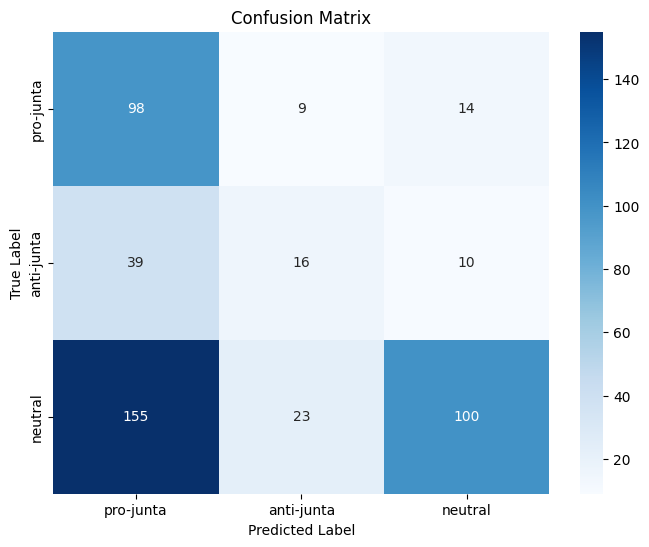


Classification Report:
              precision    recall  f1-score   support

     against      0.000     0.000     0.000         6
        anit      0.000     0.000     0.000         1
  anti-junta      0.327     0.246     0.281        65
     neutral      0.794     0.360     0.495       278
   pro-junta      0.331     0.810     0.470       121

    accuracy                          0.454       471
   macro avg      0.290     0.283     0.249       471
weighted avg      0.599     0.454     0.452       471



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
valid_rows = validation.dropna(subset=['mistral_stance', 'human_stance'])
y_true = valid_rows['human_stance']
y_pred = valid_rows['mistral_stance']

labels = ['pro-junta', 'anti-junta', 'neutral']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))
